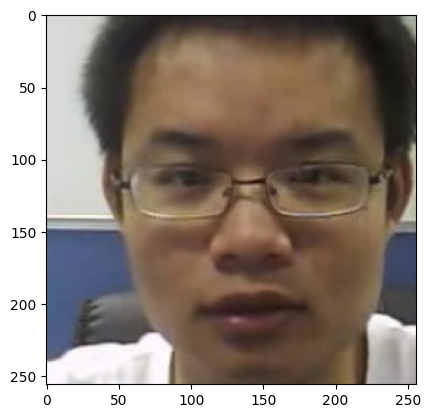

In [1]:
import cv2
from plot import imshow as show

image = cv2.imread(r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Real\14_1.avi_125_real.jpg")
show(image)

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def resize_and_cvt(image):
    image = cv2.resize(image, (128,128))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return gray_image

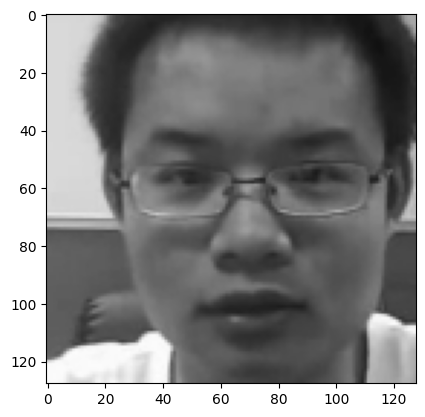

In [4]:
gray_image = resize_and_cvt(image)
show(gray_image)

In [5]:
def apply_dog(image, sigma1, sigma2):
    blur1 = cv2.GaussianBlur(image, (0,0), sigma1)
    blur2 = cv2.GaussianBlur(image, (0,0), sigma2)
    
    dog = cv2.subtract(blur1, blur2)
    return dog

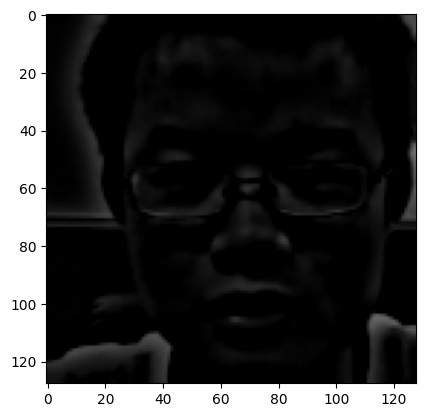

In [6]:
dog1 = apply_dog(gray_image, 0.5, 5)

show(dog1)

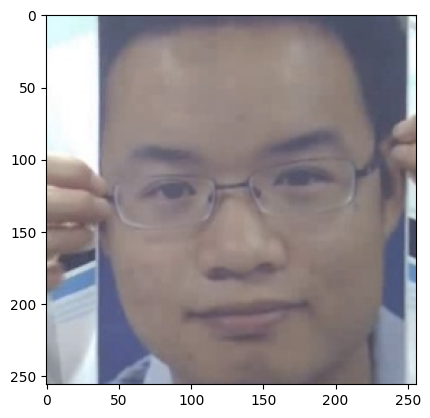

In [7]:
f_image = cv2.imread(r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Fake\14_4.avi_50_fake.jpg")
show(f_image)

In [8]:
f_image = resize_and_cvt(f_image)

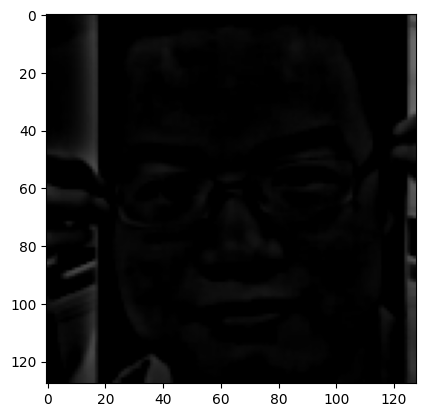

In [9]:
fake_i = apply_dog(f_image, 0.5, 5)
show(fake_i)

In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.optim as optim

transforms = transforms.Compose([transforms.Resize((128,128)), transforms.GaussianBlur(kernel_size=1, sigma=(0.5,5)), transforms.ToTensor()])

full_dataset = ImageFolder(r"C:\Users\Ruchir\OneDrive\Desktop\DOG", transform=transforms)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Classes: {full_dataset.classes}")

Classes: ['Fake', 'Real']


In [12]:
images, labels = next(iter(train_loader))

print("Batch shape: ", images.shape, "Labels: ", labels)

Batch shape:  torch.Size([32, 3, 128, 128]) Labels:  tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1])


In [13]:
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        
        return self.fc2(x)

In [14]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct/total
    return accuracy

In [16]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    test_accuracy = evaluate(model, test_loader, device)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}, Accuracy: {test_accuracy}")

print("Training Complete")

Epoch: 1/10, Loss: 0.992413156190697, Accuracy: 52.18500797448166
Epoch: 2/10, Loss: 0.6913318743511122, Accuracy: 52.18500797448166
Epoch: 3/10, Loss: 0.6915920448242402, Accuracy: 52.18500797448166


KeyboardInterrupt: 

In [ ]:
from PIL import Image

img = cv2.imread(r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Fake\5_HR_2.avi_50_fake.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = Image.fromarray(img)
img = transforms(img)
img = img.unsqueeze(0)
torch.argmax(model(img.to(device))).item()

0